In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.integrate import odeint
from copy import deepcopy
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import scipy
%matplotlib inline

# Determine growth rate of oral and gut bacteria

In [5]:
df_oral_taxa = pd.read_csv("../../databases/fHOMD/oral_typical_species.csv")
df_oral_taxa.head()

,taxon,MeanRelabunOral,PrevalenceOral,MeanRelabunGut,PrevalenceGut,species,species_binomial
0,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.550773,0.458484,0.000039,0.009404,Actinobaculum_sp_oral_taxon_183,Actinobaculum sp
1,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.143748,0.395307,0.000021,0.009404,Actinomyces_johnsonii,Actinomyces johnsonii
2,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.354643,0.402527,0.000000,0.000000,Actinomyces_massiliensis,Actinomyces massiliensis
3,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.505413,0.635379,0.000074,0.018809,Actinomyces_naeslundii,Actinomyces naeslundii
4,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.127484,0.500000,0.000110,0.034483,Actinomyces_sp_S6_Spd3,Actinomyces sp


In [10]:
df_growth = pd.read_csv("tbl_max_growth.csv")
df_growth = df_growth[df_growth.medium=="AGORA_WD"]
df_growth['species_binomial'] = [(' ').join(x.split('_')[0:2]) for x in df_growth.agoraid]
df_growth['is_oral'] = ['Yes' if x in list(df_oral_taxa.species_binomial) else 'No' for x in df_growth.species_binomial]
df_growth.head()

,agoraid,max_growth_rate,medium,species_binomial,is_oral
4908,Abiotrophia_defectiva_ATCC_49176,0.229485,AGORA_WD,Abiotrophia defectiva,No
4909,Achromobacter_xylosoxidans_A8,0.402918,AGORA_WD,Achromobacter xylosoxidans,No
4910,Achromobacter_xylosoxidans_NBRC_15126,0.217327,AGORA_WD,Achromobacter xylosoxidans,No
4911,Acidaminococcus_fermentans_DSM_20731,0.200883,AGORA_WD,Acidaminococcus fermentans,No
4912,Acidaminococcus_intestini_RyC_MR95,0.066094,AGORA_WD,Acidaminococcus intestini,No


In [11]:
df_growth.groupby('is_oral')['max_growth_rate'].agg(np.mean)

is_oral
No     0.350523
Yes    0.225570
Name: max_growth_rate, dtype: float64

In [12]:
len(df_growth[df_growth.is_oral=='Yes']),len(df_growth[df_growth.is_oral=='No'])

(60, 758)

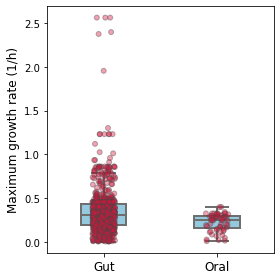

In [13]:
fig, ax = plt.subplots(figsize=(4,4))

_ = sns.boxplot(x="is_oral", y="max_growth_rate", data=df_growth, ax=ax,
                width=0.4, color="skyblue", linewidth=2, showfliers=False
               )
_ = sns.stripplot(x="is_oral", y="max_growth_rate", data=df_growth, ax=ax,
                  color="crimson", linewidth=1, alpha=0.4
                 )
_ = ax.set_xticklabels(['Gut','Oral'], fontsize=12)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Maximum growth rate (1/h)', fontsize=12)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("gut_oral_bact_growth_rate.svg", dpi=600, bbox_inches='tight')

# Parameters

In [18]:
alpha_o = 3.10e5 # oral-gut transmission rate
K_o = 1.39e9 # carrying capacity of oral bacteria, cfu/g
K_g = 2.92e10 # carrying capacity of gut bacteria, cfu/g
gamma_o = 0.23 # maximum growth rate of oral bacteria, 1/h
gamma_g = 0.35 # maximum growht rate of gut bacteria, 1/h
D = 0.08 # fecal excretion rate, 1/h

# Model

In [21]:
def glv(y, t, eps_o, eps_g, tstop):
    B_o, B_g = y
    if t <= tstop:
        epsilon_o_prime = eps_o
        epsilon_g_prime = eps_g
    else:
        epsilon_o_prime = 1
        epsilon_g_prime = 1
    dydt = [
        alpha_o + gamma_o * (1-B_o/K_o-B_g/K_g) * B_o * epsilon_o_prime - D*B_o,
                  gamma_g * (1-B_o/K_o-B_g/K_g) * B_g * epsilon_g_prime - D*B_g
    ]
    return dydt

# Plot gut and oral bacterial load over time

In [22]:
epsilon_o = np.linspace(0,1,11)
epsilon_g = np.linspace(0,1,11)
tend = 100 # simulation time

In [23]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,2000,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        tspan = np.linspace(0, tend, int(tend)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Gutf'] = 1-df2['Oralf']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        df2['Epsilon_diff'] = eps_o-eps_g
        if df is None:
            df = deepcopy(df2)
        else:
            df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

,Time,B_o,B_g,Loadt,Oralf,Gutf,Epsilon_o,Epsilon_g,Epsilon_diff
0,0.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,0.0,0.0,0.0
1,1.0,1.073106e+07,2.057468e+10,2.058542e+10,0.000521,0.999479,0.0,0.0,0.0
2,2.0,1.020394e+07,1.899283e+10,1.900303e+10,0.000537,0.999463,0.0,0.0,0.0
3,3.0,9.717351e+06,1.753259e+10,1.754231e+10,0.000554,0.999446,0.0,0.0,0.0
4,4.0,9.268169e+06,1.618462e+10,1.619389e+10,0.000572,0.999428,0.0,0.0,0.0


## oral bacteria

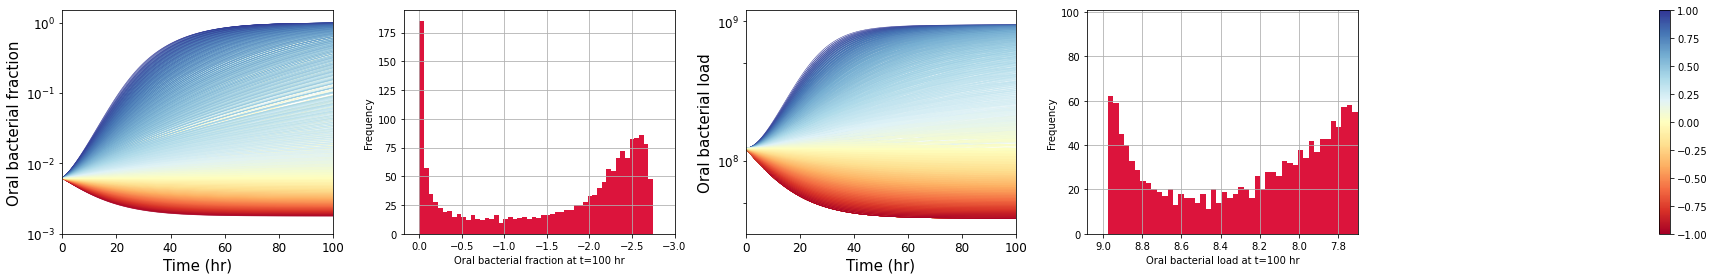

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(24,4))

# plot trajectory of oral bacterial fraction
palette='RdYlBu'
norm = plt.Normalize(-1,1)
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
        _ = sns.lineplot(x="Time", y='Oralf', hue='Epsilon_diff', data=curr_df, ax=ax[0], palette=palette, hue_norm=(-1,1), zorder=-10, linewidth=0.5)
        if ax[0].get_legend() is not None:
            _ = ax[0].get_legend().remove()
_ = ax[0].set_xlim([0,100])
_ = ax[0].set_yscale('log')
_ = ax[0].minorticks_off()
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)
_ = ax[0].set_xlabel('Time (hr)', fontsize=15)
_ = ax[0].set_ylabel('Oral bacterial fraction', fontsize=15)
_ = ax[0].set_ylim([1e-3,1.5])

# histogram of oral bacterial fraction
_ = np.log10(df[df.Time==100].Oralf).hist(bins=50, ax=ax[1], color='#DC143C')
_ = ax[1].set_xlabel('Oral bacterial fraction at t=100 hr')
_ = ax[1].set_ylabel('Frequency')
_ = ax[1].set_xlim([-3,np.log10(1.5)])
_ = ax[1].invert_xaxis()

# plot trajectory of absolute abundance of oral bacteria
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
        _ = sns.lineplot(x="Time", y='B_o', hue='Epsilon_diff', data=curr_df, ax=ax[2], palette=palette, hue_norm=(-1,1), zorder=-10, linewidth=0.5)
        if ax[2].get_legend() is not None:
            _ = ax[2].get_legend().remove()
_ = ax[2].set_xlim([0,100])
_ = ax[2].set_yscale('log')
_ = ax[2].minorticks_off()
_ = ax[2].tick_params(axis='both', which='major', labelsize=12)
_ = ax[2].set_xlabel('Time (hr)', fontsize=15)
_ = ax[2].set_ylabel('Oral bacterial load', fontsize=15)
_ = ax[2].set_ylim([3e7,1.2e9])
_ = ax[2].set_yticks([5e7,1e8,5e8,1e9])

# histogram of oral bacterial load
_ = np.log10(df[df.Time==100].B_o).hist(bins=50, ax=ax[3], color='#DC143C')
_ = ax[3].set_xlabel('Oral bacterial load at t=100 hr')
_ = ax[3].set_ylabel('Frequency')
_ = ax[3].set_xlim([np.log10(5e7),np.log10(1.2e9)])
_ = ax[3].invert_xaxis()

# plot colorbar
_ = ax[4].figure.colorbar(sm)
_ = ax[4].axis('off')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("simulated_oral_bacteria_vary_parameters.svg", dpi=600, bbox_inches='tight')

## gut bacteria

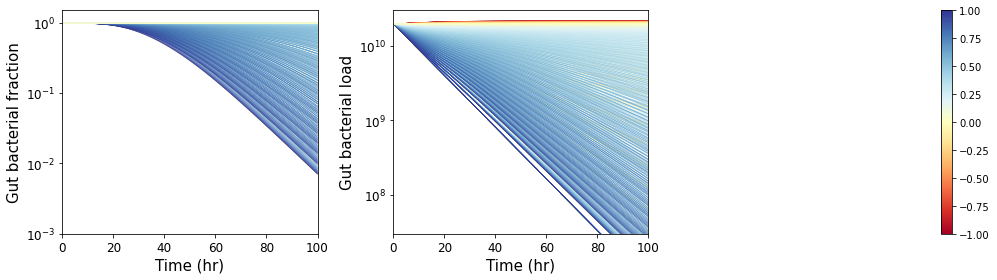

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

# plot trajectory of oral bacterial fraction
palette='RdYlBu'
norm = plt.Normalize(-1,1)
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
        _ = sns.lineplot(x="Time", y='Gutf', hue='Epsilon_diff', data=curr_df, ax=ax[0], palette=palette, hue_norm=(-1,1), zorder=-10, linewidth=0.5)
        if ax[0].get_legend() is not None:
            _ = ax[0].get_legend().remove()
_ = ax[0].set_xlim([0,100])
_ = ax[0].set_yscale('log')
_ = ax[0].minorticks_off()
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)
_ = ax[0].set_xlabel('Time (hr)', fontsize=15)
_ = ax[0].set_ylabel('Gut bacterial fraction', fontsize=15)
_ = ax[0].set_ylim([1e-3,1.5])


# plot trajectory of absolute abundance of oral bacteria
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
        _ = sns.lineplot(x="Time", y='B_g', hue='Epsilon_diff', data=curr_df, ax=ax[1], palette=palette, hue_norm=(-1,1), zorder=-10, linewidth=0.5)
        if ax[1].get_legend() is not None:
            _ = ax[1].get_legend().remove()
_ = ax[1].set_xlim([0,100])
_ = ax[1].set_yscale('log')
_ = ax[1].minorticks_off()
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
_ = ax[1].set_xlabel('Time (hr)', fontsize=15)
_ = ax[1].set_ylabel('Gut bacterial load', fontsize=15)
_ = ax[1].set_ylim([3e7,3e10])
_ = ax[1].set_yticks([1e8,1e9,1e10])


# plot colorbar
_ = ax[2].figure.colorbar(sm)
_ = ax[2].axis('off')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("simulated_gut_bacteria_vary_parameters.svg", dpi=600, bbox_inches='tight')

# Plot total bacterial load vs. oral bacterial fraction

In [33]:
epsilon_o = [0] + list(10**(np.linspace(-2,0,41)))
epsilon_g = [0] + list(10**(np.linspace(-2,0,41)))
tend = 2000 # simulation time

In [34]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,2000,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        tspan = np.linspace(0, tend, int(tend/5)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        df2['Epsilon_diff'] = eps_o-eps_g
        if df is None:
            df = deepcopy(df2)
        else:
            df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

,Time,B_o,B_g,Loadt,Oralf,Epsilon_o,Epsilon_g,Epsilon_diff
0,0.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.0,0.0,0.0
1,5.0,8.853523e+06,1.494029e+10,1.494914e+10,0.000592,0.0,0.0,0.0
2,10.0,7.212204e+06,1.001477e+10,1.002199e+10,0.000720,0.0,0.0,0.0
3,15.0,6.111995e+06,6.713104e+09,6.719216e+09,0.000910,0.0,0.0,0.0
4,20.0,5.374502e+06,4.499928e+09,4.505303e+09,0.001193,0.0,0.0,0.0


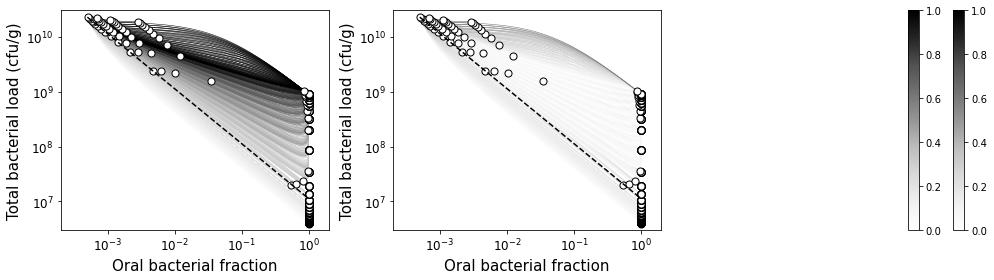

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

for k,hue in enumerate(['Epsilon_o','Epsilon_g']):
    
    # create palette
    palette='Greys'
    norm = plt.Normalize(0,1)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    
    # plot trajectories
    for eps_o in epsilon_o:
        for eps_g in epsilon_g:
            if eps_o >= eps_g:
                curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
                _ = ax[k]
                _ = sns.lineplot(x='Oralf', y='Loadt', hue=hue, data=curr_df, ax=ax[k], palette=palette, hue_norm=(0,1), zorder=-10, linewidth=0.5)
                xfinal = curr_df.iloc[-1].Oralf
                yfinal = curr_df.iloc[-1].Loadt
                _ = ax[k].scatter(xfinal, yfinal, s=50, facecolors='white', edgecolors='black')
                
                if ax[k].get_legend() is not None:
                    _ = ax[k].get_legend().remove()

    _ = ax[k].set_xscale('log')
    _ = ax[k].set_yscale('log')
    _ = ax[k].minorticks_off()
    _ = ax[k].tick_params(axis='both', which='major', labelsize=12)
    _ = ax[k].set_xlabel('Oral bacterial fraction', fontsize=15)
    _ = ax[k].set_ylabel('Total bacterial load (cfu/g)', fontsize=15)
    _ = ax[k].plot([5e-4,1],[steady_state[0]/5e-4, steady_state[0]/1], 'k--')
    _ = ax[k].set_xlim([2e-4,2])
    _ = ax[k].set_ylim([3e6,3e10])
    _ = ax[2].figure.colorbar(sm)
    
_ = ax[2].axis('off')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("phase_plot.svg", dpi=600, bbox_inches='tight')

## get triangle slope

In [28]:
# lower bound
(np.log(np.sum(steady_state))-np.log(alpha_o/D))/(np.log(steady_state[0]/np.sum(steady_state)))

-1.1410826320682128

In [29]:
# upper bound
(np.log(np.sum(steady_state))-np.log((K_o*(gamma_o-D)+np.sqrt(K_o**2*(D-gamma_o)**2+4*alpha_o*gamma_o*K_o))/2/gamma_o))/(np.log(steady_state[0]/np.sum(steady_state)))

-0.42181292158449024

# Plot heatmap of slope and correlation

In [42]:
#epsilon_o = 10**(np.linspace(-2,0,41))
#epsilon_g = 10**(np.linspace(-2,0,41))
epsilon_o = [float('%2.2f'%(x)) for x in np.linspace(0,1,41)]
epsilon_g = [float('%2.2f'%(x)) for x in np.linspace(0,1,41)]
tend = 2000 # simulation time

In [43]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,tend,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        tspan = np.linspace(0, tend, int(tend/5)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        if df is None:
            df = deepcopy(df2)
        else:
            df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

,Time,B_o,B_g,Loadt,Oralf,Epsilon_o,Epsilon_g
0,0.0,1.232955e+08,1.993562e+10,2.005892e+10,0.006147,0.0,0.0
1,5.0,9.542251e+07,1.336325e+10,1.345867e+10,0.007090,0.0,0.0
2,10.0,7.673872e+07,8.957653e+09,9.034392e+09,0.008494,0.0,0.0
3,15.0,6.421460e+07,6.004494e+09,6.068709e+09,0.010581,0.0,0.0
4,20.0,5.581943e+07,4.024933e+09,4.080752e+09,0.013679,0.0,0.0


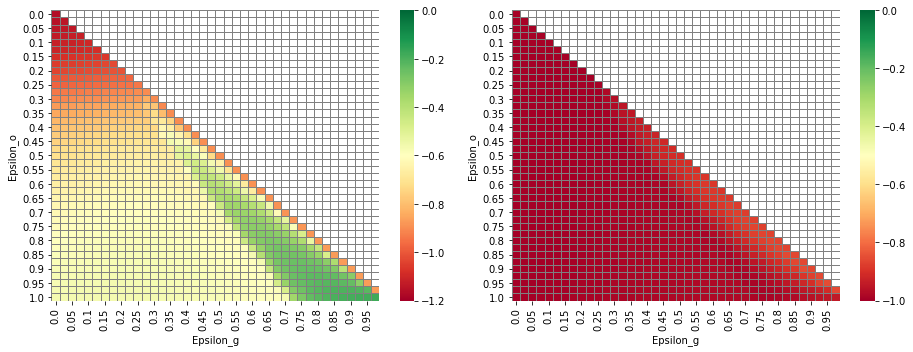

In [44]:
# plot slope
slope = []
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        if eps_o >= eps_g:
            if eps_o == eps_g and eps_o == 1.0:
                # trajectory will stay at steady state
                continue
            else:
                # cannot do interpolation if we include oral fraction = 1
                curr_df = df.loc[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g), ['Oralf','Loadt']].drop_duplicates()
                curr_df['Oralf'] = curr_df['Oralf'].apply(lambda x: format(float(x),".6f")).astype(float)
                curr_df = curr_df.drop_duplicates(subset=['Oralf'])
                if len(curr_df) <= 10:
                    xnew = list(np.log10(curr_df.Oralf))
                    ynew = list(np.log10(curr_df.Loadt))
                else:
                    f2 = interp1d(np.log10(curr_df.Oralf), np.log10(curr_df.Loadt), kind='linear')
                    xnew = np.linspace(np.log10(curr_df.Oralf.min()), np.log10(curr_df.Oralf.max()), 10)
                    ynew = f2(xnew)
                rng=np.random.RandomState(42)
                #huber = HuberRegressor().fit(np.array(xnew).reshape(-1,1), np.array(ynew))
                fit = scipy.stats.linregress(xnew, ynew)
                psr = pearsonr(xnew, ynew)
                #slope.append([eps_o, eps_g, huber.coef_[0], psr[0]])
                slope.append([eps_o, eps_g, fit.slope, psr[0]])
            
df2plot = pd.DataFrame(slope, columns=['Epsilon_o','Epsilon_g','Slope','Correlation'])
df2plot = df2plot.sort_values(['Epsilon_o','Epsilon_g'])
df2plot['Epsilon_o'] = df2plot['Epsilon_o'].astype(str)
df2plot['Epsilon_g'] = df2plot['Epsilon_g'].astype(str)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

# slope
df_slope = pd.pivot_table(df2plot, index='Epsilon_o', columns='Epsilon_g', values='Slope')
#index = [str("%2.2f" % x) for x in np.log10(epsilon_o)]
#df_slope = df_slope.loc[index[::-1], index]
x = list(df2plot.Epsilon_o)
y = list(df2plot.Epsilon_g)
vals = list(df2plot.Slope)
X, Y = np.meshgrid(epsilon_o, epsilon_g)

interpolated_vals = griddata((x, y), vals, (X, Y), method='linear')
#_ = ax[0].contourf(X, Y, interpolated_vals, cmap='RdYlGn', vmin=-1.1, vmax=0.1)
_ = sns.heatmap(df_slope, ax=ax[0], cmap="RdYlGn", vmin=-1.2, vmax=0, linewidth=0.5, linecolor='gray') 
#for x,y in zip([-0.8,-0.55,-0.3],[-1.0,-1.0,-1.0]):
#    _ = ax[0].scatter(x,y,s=100,marker='x',color='k')

# pearson correlation
df_corr = pd.pivot_table(df2plot, index='Epsilon_o', columns='Epsilon_g', values='Correlation')
#df_corr.loc["0.00","0.00"] = np.NaN
#index = [str("%2.2f" % x) for x in np.log10(epsilon_o)]
#df_corr = df_corr.loc[index[::-1], index]
x = list(df2plot.Epsilon_o)
y = list(df2plot.Epsilon_g)
vals = list(df2plot.Correlation)
X, Y = np.meshgrid(epsilon_o, epsilon_g)

interpolated_vals = griddata((x, y), vals, (X, Y), method='linear')
#_ = ax[1].contourf(X, Y, interpolated_vals, cmap='RdYlGn', vmin=-1, vmax=0)
_ = sns.heatmap(df_corr, ax=ax[1], cmap="RdYlGn", vmin=-1, vmax=0, linewidth=0.5, linecolor='gray') 
#for x,y in zip([-0.8,-0.55,-0.3],[-1.0,-1.0,-1.0]):
#    _ = ax[1].scatter(x,y,s=100,marker='x',color='k')
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bacteriostatic_heatmap_slope_pearsoncorr_log.svg", dpi=600, bbox_inches='tight')

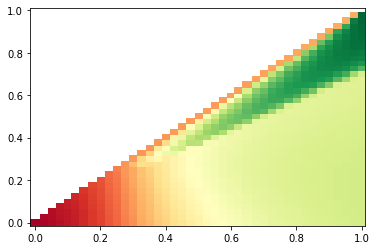

In [55]:
X, Y = np.meshgrid(epsilon_g, epsilon_o)
Z = df_slope
Z[1.00] = np.NaN
plt.pcolor(X, Y, Z.T, cmap='RdYlGn', shading="auto")

In [45]:
# min and max of slope
[df_slope.min().min(), df_slope.max().max()]

[-1.1650722768283879, -0.1821690875825206]

In [46]:
# min and max of correlation
[df_corr.min().min(), df_corr.max().max()]

[-0.9989002535111111, -0.8540357345955317]

# Simulation plot specific trajectories

In [48]:
epsilon_o=[0.0,0.20,0.70]
epsilon_g=[0.05,0.05,0.05]
tend = 2000 # simulation time

In [49]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,tend,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o, eps_g in zip(epsilon_o, epsilon_g):
    tspan = np.linspace(0, tend, int(tend/5)+1)
    sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
    df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
    df2['Loadt'] = df2['B_o']+df2['B_g']
    df2['Oralf'] = df2['B_o']/df2['Loadt']
    df2['log10_Loadt'] = np.log10(df2.Loadt)
    df2['log10_Oralf'] = np.log10(df2.Oralf)
    df2['Epsilon_o'] = eps_o
    df2['Epsilon_g'] = eps_g
    df2['log10_Epsilon_o'] = np.log10(eps_o)
    df2['log10_Epsilon_g'] = np.log10(eps_g)
    df2['Epsilon_ratio'] = eps_o/eps_g
    df2['log10_Epsilon_ratio'] = np.log10(eps_o/eps_g)
    if df is None:
        df = deepcopy(df2)
    else:
        df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

<ipython-input-49-cef1eb708377>:17: RuntimeWarning: divide by zero encountered in log10
  df2['log10_Epsilon_o'] = np.log10(eps_o)
<ipython-input-49-cef1eb708377>:20: RuntimeWarning: divide by zero encountered in log10
  df2['log10_Epsilon_ratio'] = np.log10(eps_o/eps_g)


,Time,B_o,B_g,Loadt,Oralf,log10_Loadt,log10_Oralf,Epsilon_o,Epsilon_g,log10_Epsilon_o,log10_Epsilon_g,Epsilon_ratio,log10_Epsilon_ratio
0,0.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,10.348297,-3.295138,0.0,0.05,-inf,-1.30103,0.0,-inf
1,5.0,8.853523e+06,1.541242e+10,1.542128e+10,0.000574,10.188120,-3.241004,0.0,0.05,-inf,-1.30103,0.0,-inf
2,10.0,7.212204e+06,1.084043e+10,1.084764e+10,0.000665,10.035335,-3.177267,0.0,0.05,-inf,-1.30103,0.0,-inf
3,15.0,6.111995e+06,7.712597e+09,7.718709e+09,0.000792,9.887545,-3.101362,0.0,0.05,-inf,-1.30103,0.0,-inf
4,20.0,5.374502e+06,5.530864e+09,5.536238e+09,0.000971,9.743215,-3.012877,0.0,0.05,-inf,-1.30103,0.0,-inf


In [50]:
def glv_given_Bg(y, t, eps_o, interp, tstop, opt):
    B_o = y
    if opt=='abx_only':
        B_g = interp(0)
    elif opt=='competition_only':
        if t>np.max(interp.x):
            B_g = interp(np.max(interp.x))
        else:
            B_g = interp(t)
    if t <= tstop:
        epsilon_o_prime = eps_o
    else:
        epsilon_o_prime = 1
    if opt=='abx_only':
        dydt = alpha_o + gamma_o * (1-B_o/K_o-B_g/K_g) * B_o * epsilon_o_prime - D*B_o
    elif opt=='competition_only':
        dydt = alpha_o + gamma_o * (1-B_o/K_o-B_g/K_g) * B_o - D*B_o
        
    return dydt

<ipython-input-54-02edbb0809be>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df['Oralf'] = curr_df['Oralf'].apply(lambda x: format(float(x),".6f")).astype(float)
<ipython-input-54-02edbb0809be>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df['Oralf'] = curr_df['Oralf'].apply(lambda x: format(float(x),".6f")).astype(float)
<ipython-input-54-02edbb0809be>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

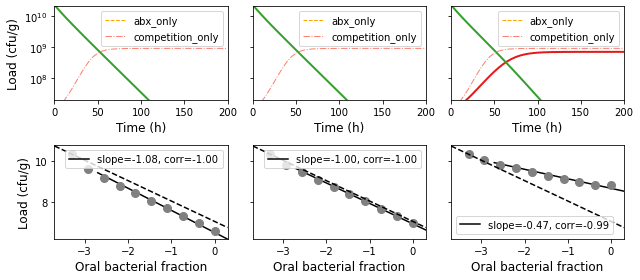

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,4), sharey='row')

my_colors = sns.color_palette("Paired")
for k,eps_o in enumerate(epsilon_o):
    # plot B_o
    curr_df = df[(df.Epsilon_o == eps_o) & (df.Time<=200)]
    _ = ax[0,k].plot(curr_df.Time, curr_df.B_o, '-', color=my_colors[5], linewidth=2)
    _ = ax[0,k].plot(curr_df.Time, curr_df.B_g, '-', color=my_colors[3], linewidth=2)
    _ = ax[0,k].plot(curr_df.Time, [steady_state[0]]*len(curr_df), 'k--')
    
    # plot perturbed trajectories with different mechanisms
    tend = 200
    tspan = np.linspace(0, tend, int(tend/5)+1)
    interp = interp1d(curr_df.Time, curr_df.B_g)
    sol1 = odeint(glv_given_Bg, steady_state[0], tspan, args=(eps_o, interp, tend, 'abx_only'))
    sol2 = odeint(glv_given_Bg, steady_state[0], tspan, args=(eps_o, interp, tend, 'competition_only'))
    df_sol1 = pd.DataFrame(sol1, index=tspan, columns=['B_o'])
    df_sol2 = pd.DataFrame(sol2, index=tspan, columns=['B_o'])
    _ = ax[0,k].plot(df_sol1.index, df_sol1.B_o, '--', color='orange', linewidth=1, label='abx_only')
    _ = ax[0,k].plot(df_sol2.index, df_sol2.B_o, '-.', color='salmon', linewidth=1, label='competition_only')
    _ = ax[0,k].set_yscale('log')
    _ = ax[0,k].set_ylim([2e7, 2e10])
    _ = ax[0,k].set_xlim([0,200])
    _ = ax[0,k].set_yticks([1e8,1e9,1e10])
    _ = ax[0,k].set_xlabel('Time (h)', fontsize=12)
    if k==0:
        _ = ax[0,k].set_ylabel('Load (cfu/g)', fontsize=12)
    else:
        _ = ax[0,k].set_ylabel('')
    _ = ax[0,k].legend()
    _ = ax[0,k].minorticks_off()
    
    # compute slope and correlation
    curr_df = df.loc[df.Epsilon_o==eps_o]
    curr_df['Oralf'] = curr_df['Oralf'].apply(lambda x: format(float(x),".6f")).astype(float)
    curr_df = curr_df.drop_duplicates(subset=['Oralf'])
    f2 = interp1d(np.log10(curr_df.Oralf), np.log10(curr_df.Loadt), kind='linear')
    xnew = np.linspace(np.log10(curr_df.Oralf.min()), np.log10(curr_df.Oralf.max()), 10)
    ynew = f2(xnew)
    rng=np.random.RandomState(42)
    psr = pearsonr(xnew, ynew)
    #huber = HuberRegressor().fit(np.array(xnew).reshape(-1,1), np.array(ynew))
    fit = scipy.stats.linregress(xnew, ynew)
    xnew2 = np.linspace(-2.7,0.3,100)
    #_ = ax[1,k].plot(xnew2, huber.intercept_+huber.coef_[0]*xnew2, 'k-', label='slope=%2.2f, corr=%2.2f'%(huber.coef_, psr[0]), zorder=-5)
    _ = ax[1,k].plot(xnew2, fit.intercept+fit.slope*xnew2, 'k-', label='slope=%2.2f, corr=%2.2f'%(fit.slope, psr[0]), zorder=-5)
    _ = ax[1,k].legend()
    _ = ax[1,k].scatter(xnew, ynew, color='gray', s=64)
    _ = ax[1,k].set_xlabel('Oral bacterial fraction', fontsize=12)
    if k==0:
        _ = ax[1,k].set_ylabel('Load (cfu/g)', fontsize=12)
    else:
        _ = ax[1,k].set_ylabel('')
    _ = ax[1,k].plot([-3.7,0.3],[np.log10(steady_state[0]/10**(-3.7)), np.log10(steady_state[0]/10**(0.3))], 'k--')
    _ = ax[1,k].set_xlim([-3.7,0.3])
    _ = ax[1,k].set_ylim([6.2,10.8])
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("illustration_antibiotics_vs_competition.svg", dpi=600, bbox_inches='tight')

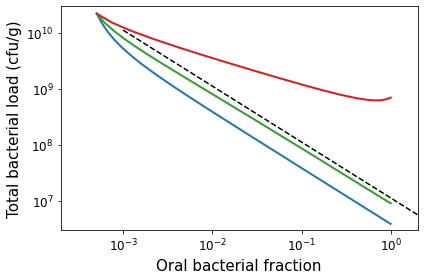

In [52]:
fig, ax = plt.subplots(figsize=(6,4))

my_colors = sns.color_palette("Paired")
for k,eps_o in enumerate(epsilon_o):
    curr_df = df[df.Epsilon_o == eps_o]
    _ = ax.plot(curr_df.Oralf, curr_df.Loadt, '-', color=my_colors[2*k+1], linewidth=2)    

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.minorticks_off()
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_xlabel('Oral bacterial fraction', fontsize=15)
_ = ax.set_ylabel('Total bacterial load (cfu/g)', fontsize=15)
_ = ax.plot([1e-3,10],[steady_state[0]/1e-3, steady_state[0]/10], 'k--')
_ = ax.set_xlim([2e-4,2])
_ = ax.set_ylim([3e6,3e10])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("representative_trajectories_log_log.svg", dpi=600, bbox_inches='tight')